In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from uncertainties import unumpy as unp
import uncertainties
import seaborn as sb
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
raw_data = pd.read_excel('data/RawData.xlsx')
raw_data = raw_data[~raw_data.units.str.contains('trap')]

TypeError: bad operand type for unary ~: 'float'

### 1) Remove non-mass measurements

In [3]:
raw_data.reference.nunique()

100

In [4]:
raw_data.columns

Index(['ID', 'site', 'coordinates', 'depth', 'country', 'biome',
       'standard biome', 'aggregated biome', 'altitude',
       'mean annual temperature', 'mean annual percipitation (mm yr^-1)',
       'environment (soil,litter, trees)', 'aggregated environment', 'taxon',
       'family', 'super-family', 'order', 'sub-class', 'class', 'sub-phylum',
       'phylum', 'numerical value', 'standard deviation', 'units', 'reference',
       'link (doi)', 'source in text', 'season', 'date', 'remarks',
       'studied group', 'synthetic coordinates', 'mark for deletion',
       'Recommended action', 'explain action'],
      dtype='object')

In [5]:
mass_data = raw_data[raw_data.units.str.startswith('mg')]
mass_data['norm value'] = mass_data['numerical value']
mass_data.loc[mass_data.units=='mg/m^2 (wet weight)','norm value'] = mass_data.loc[mass_data.units=='mg/m^2 (wet weight)','norm value']*0.3

<ipython-input-5-b2560475b11e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mass_data['norm value'] = mass_data['numerical value']
/home/yinonbaron/.local/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [6]:
# mass_data = raw_data[raw_data.units=='mg/m^2 (dry weight)']

In [7]:
metadata = pd.read_csv('data/groups_per_reference.csv')
mass_data_with_meta = mass_data.merge(metadata,left_on='reference', right_on='Paper',how='left')

In [8]:
mass_data_with_meta.groupby('Standard groups')['site'].nunique()

Standard groups
Acari                  9
Arthropods           174
Collembola, Acari     48
Formicidae            49
Isoptera              12
Macroarthropods       25
Microarthropods        2
Orthoptera             1
Some arthropods        4
Name: site, dtype: int64

In [9]:
raw_data_with_meta = raw_data.merge(metadata,left_on='reference', right_on='Paper',how='left')
raw_data_val = raw_data_with_meta[(raw_data_with_meta['Standard groups']!='Microarthropods') | ((raw_data_with_meta['Standard groups']=='Microarthropods') & (raw_data_with_meta['sub-class'].isin(['Acari','Collembola'])))]
raw_data_val = raw_data_val[~raw_data_val['Standard groups'].isna()]
raw_data_val.groupby(['aggregated environment']).site.nunique()

aggregated environment
above ground     34
plants           51
soil/litter     300
Name: site, dtype: int64

In [10]:
valid_data = mass_data_with_meta.copy()
valid_data = valid_data[(valid_data['Standard groups']!='Microarthropods') | ((valid_data['Standard groups']=='Microarthropods') & (valid_data['sub-class'].isin(['Acari','Collembola'])))]

In [11]:
valid_data.loc[valid_data['sub-class']=='Acari','aggregated taxon'] = 'Acari'
valid_data.loc[valid_data['sub-class']=='Collembola','aggregated taxon'] = 'Collembola'
valid_data.loc[valid_data['super-family']=='Isoptera','aggregated taxon'] = 'Isoptera'
valid_data.loc[valid_data['family']=='Formicidae','aggregated taxon'] = 'Formicidae'
valid_data.loc[valid_data['aggregated taxon'].isna(),'aggregated taxon'] = 'Other'

In [12]:
soil_data = valid_data[valid_data['aggregated environment'] =='soil/litter']
canopy_data = valid_data[valid_data['aggregated environment'] =='plants']
surface_data = valid_data[valid_data['aggregated environment'] =='above ground']

In [13]:
soil_data.pivot_table(columns='aggregated taxon',values='site',index='aggregated biome', aggfunc='nunique')

aggregated taxon,Acari,Collembola,Formicidae,Isoptera,Other
aggregated biome,,,,,
Boreal Forests/Taiga,22.0,21.0,NaN,NaN,16.0
Crops,NaN,NaN,6.0,29.0,9.0
Deserts and Xeric Shrublands,1.0,1.0,4.0,1.0,NaN
"Mediterranean Forests, Woodlands and Scrub",NaN,NaN,1.0,2.0,NaN
Pasture,7.0,7.0,7.0,20.0,10.0
Shrubland/Grassland,NaN,NaN,13.0,NaN,NaN
Temperate Forests,46.0,43.0,25.0,6.0,31.0
"Temperate Grasslands, Savannas and Shrublands",17.0,18.0,10.0,2.0,16.0
Tropical and Subtropical Forests,5.0,6.0,21.0,40.0,19.0


In [14]:
# placeholder for ants
shrub_index = soil_data.loc[(soil_data['family'] == 'Formicidae') & (soil_data['aggregated biome'] == 'Shrubland/Grassland')].index
soil_data.loc[shrub_index[0:8],'aggregated biome'] = 'Temperate Grasslands, Savannas and Shrublands'
soil_data.loc[shrub_index[8:],'aggregated biome'] = 'Tropical and Subtropical Grasslands, Savannas and Shrublands'

/home/yinonbaron/.local/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [15]:
soil_site_data = soil_data.groupby(['aggregated taxon','aggregated biome','site'])['norm value'].sum()
soil_biome_means = soil_site_data.groupby(['aggregated taxon','aggregated biome']).agg(['mean','count','sem'])
soil_biome_means.reset_index().pivot_table(columns='aggregated taxon',index='aggregated biome').to_csv('results/biome_means.csv')

soil_biome_means['umean'] = unp.uarray(nominal_values=soil_biome_means['mean'],std_devs=soil_biome_means['sem'])
soil_biome_means = soil_biome_means[['count','umean']]
soil_biome_means

/usr/lib/python3/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


count  \
aggregated taxon aggregated biome                                            
Acari            Boreal Forests/Taiga                                   22   
                 Deserts and Xeric Shrublands                            1   
                 Pasture                                                 7   
                 Temperate Forests                                      46   
                 Temperate Grasslands, Savannas and Shrublands          17   
                 Tropical and Subtropical Forests                        5   
                 Tropical and Subtropical Grasslands, Savannas a...      2   
                 Tundra                                                 48   
Collembola       Boreal Forests/Taiga                                   21   
                 Deserts and Xeric Shrublands                            1   
                 Pasture                                                 7   
                 Temperate Forests                                      43   
                 Temperate Grasslands, Savannas and Shrublands          18   
                 Tropical and Subtropical Forests                        6   
                 Tropical and Subtropical Grasslands, Savannas a...      2   
                 Tundra                                                 35   
Formicidae       Crops                                                   6   
                 Deserts and Xeric Shrublands                            4   
                 Mediterranean Forests, Woodlands and Scrub              1   
                 Pasture                                                 7   
                 Temperate Forests                                      25   
                 Temperate Grasslands, Savannas and Shrublands          18   
                 Tropical and Subtropical Forests                       21   
                 Tropical and Subtropical Grasslands, Savannas a...      8   
                 Tundra                                                  1   
Isoptera         Crops                                                  29   
                 Deserts and Xeric Shrublands                            1   
                 Mediterranean Forests, Woodlands and Scrub              2   
                 Pasture                                                20   
                 Temperate Forests                                       6   
                 Temperate Grasslands, Savannas and Shrublands           2   
                 Tropical and Subtropical Forests                       40   
                 Tropical and Subtropical Grasslands, Savannas a...     15   
                 Tundra                                                  1   
Other            Boreal Forests/Taiga                                   16   
                 Crops                                                   9   
                 Pasture                                                10   
                 Temperate Forests                                      31   
                 Temperate Grasslands, Savannas and Shrublands          16   
                 Tropical and Subtropical Forests                       19   
                 Tropical and Subtropical Grasslands, Savannas a...      5   
                 Tundra                                                 14   

                                                                                        umean  
aggregated taxon aggregated biome                                                              
Acari            Boreal Forests/Taiga                                         (5.2+/-1.0)e+02  
                 Deserts and Xeric Shrublands                        109.74000000000001+/-nan  
                 Pasture                                                          (6+/-6)e+02  
                 Temperate Forests                                          (1.06+/-0.27)e+03  
                 Temperate Grasslands, Savannas and Shrublan

In [16]:
def calc_uval(x):
    return unp.uarray(nominal_values=np.mean(x),std_devs=x.sem())

soil_site_taxa_mean = soil_data.groupby(['aggregated taxon','aggregated biome','site','taxon'])['norm value'].mean().reset_index()
soil_site_data = soil_site_taxa_mean.groupby(['aggregated taxon','aggregated biome','site'])['norm value'].sum()
soil_biome_means = soil_site_data.reset_index().pivot_table(index='aggregated taxon',columns='aggregated biome',values='norm value', aggfunc=[calc_uval,'count'])

soil_biome_means = soil_biome_means.unstack().reset_index().pivot_table(index='aggregated taxon', columns=['aggregated biome','level_0'],values=0,aggfunc=sum)
soil_biome_means.columns = soil_biome_means.columns.set_levels(['mean','N'],1)
def print_u(x):
    if type(x) != uncertainties.core.Variable:
        return '{:.0f}'.format(x )
    else: 
        return '{:.0f}'.format(x.nominal_value)+'±'+'{:.0f}'.format(x.std_dev)

soil_biome_means_print = soil_biome_means.applymap(print_u)
soil_biome_means_print.to_csv('results/table_1.csv')

/usr/lib/python3/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [17]:
soil_biome_means_print

aggregated biome Boreal Forests/Taiga         Crops      \
level_0                          mean   N      mean   N   
aggregated taxon                                          
Acari                          377±63  22         0   0   
Collembola                    443±248  21         0   0   
Formicidae                          0   0     49±17   6   
Isoptera                            0   0  1486±359  29   
Other                          264±62  16  1129±469   9   

aggregated biome Deserts and Xeric Shrublands     \
level_0                                  mean  N   
aggregated taxon                                   
Acari                                   9±nan  1   
Collembola                              1±nan  1   
Formicidae                              72±37  4   
Isoptera                              246±nan  1   
Other                                       0  0   

aggregated biome Mediterranean Forests, Woodlands and Scrub     Pasture      \
level_0                                                mean  N     mean   N   
aggregated taxon                                                              
Acari                                                     0  0    43±41   7   
Collembola                                                0  0      4±4   7   
Formicidae                                           39±nan  1   129±32   7   
Isoptera                                           1200±390  2  619±273  20   
Other                                                     0  0  751±208  10   

aggregated biome Temperate Forests      \
level_0                       mean   N   
aggregated taxon                         
Acari                      862±208  46   
Collembola                  299±94  43   
Formicidae                 717±629  25   
Isoptera                   409±262   6   
Other                     1061±184  31   

aggregated biome Temperate Grasslands, Savannas and Shrublands      \
level_0                                                   mean   N   
aggregated taxon                                                     
Acari                                                   279±75  17   
Collembola                                              179±46  18   
Formicidae                                              192±93  18   
Isoptera                                               780±780   2   
Other                                                  655±235  16   

aggregated biome Tropical and Subtropical Forests      \
level_0                                      mean   N   
aggregated taxon                                        
Acari                                      162±83   5   
Collembola                                  49±28   6   
Formicidae                                 140±74  21   
Isoptera                                 2540±727  40   
Other                                     812±226  19   

aggregated biome Tropical and Subtropical Grasslands, Savannas and Shrublands  \
level_0                                                                  mean   
aggregated taxon                                                                
Acari                                                         74±47             
Collembola                                                     12±1             
Formicidae                                                   256±72             
Isoptera                                                   1394±570             
Other                                                       165±142             

aggregated biome       Tundra      
level_0            N     mean   N  
aggregated taxon                   
Acari              2   212±42  48  
Collembola         2  388±146  35  
Formicidae         8    0±nan   1  
Isoptera          15    0±nan   1  
Other              5    64±36  14

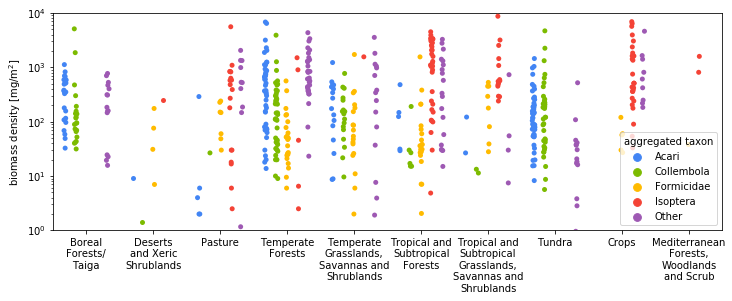

In [18]:
pal = sb.color_palette(['#4285F4','#7CBB00','#FFBB00','#f44336','#9e59b3'])
r = soil_site_data.reset_index()

original_biomes = r['aggregated biome'].unique()
# r.repl
print_biomes = ['Boreal\nForests/\nTaiga','Deserts\nand Xeric\nShrublands','Pasture','Temperate\nForests','Temperate\nGrasslands,\nSavannas and\nShrublands','Tropical and\nSubtropical\nForests','Tropical and\nSubtropical\nGrasslands,\nSavannas and\nShrublands','Tundra','Crops','Mediterranean\nForests,\nWoodlands\nand Scrub']
r2 = r.replace(to_replace=original_biomes,value=print_biomes)
fig,ax = plt.subplots(figsize=[12,4])
sb.stripplot(x='aggregated biome',y='norm value',hue='aggregated taxon',data=r2,dodge=True,palette=pal,ax=ax)
ax.set_yscale('log')
ax.set_ylim([1,10000])
ax.set_ylabel('biomass density [mg/m$^2$]')
ax.set_xlabel('')
plt.savefig('results/test_fig2.svg',dpi=300)


In [19]:
def legend_without_duplicate_labels(ax,pos):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique),bbox_to_anchor=pos)

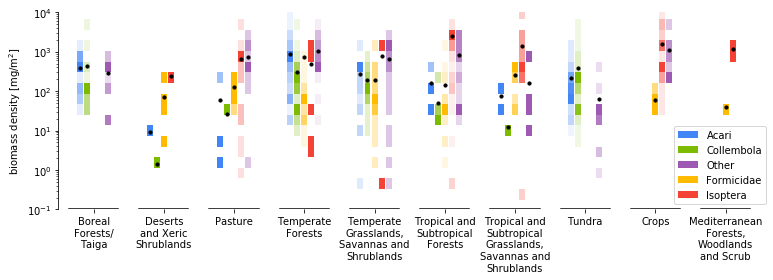

In [20]:
r = soil_site_data.reset_index()
original_biomes = r['aggregated biome'].unique()
# r.repl
print_biomes = ['Boreal\nForests/\nTaiga','Deserts\nand Xeric\nShrublands','Pasture','Temperate\nForests','Temperate\nGrasslands,\nSavannas and\nShrublands','Tropical and\nSubtropical\nForests','Tropical and\nSubtropical\nGrasslands,\nSavannas and\nShrublands','Tundra','Crops','Mediterranean\nForests,\nWoodlands\nand Scrub']
r2 = r.replace(to_replace=original_biomes,value=print_biomes)

r4 = r2.loc[r2['norm value']>0]
bins = np.logspace(np.log10(r4['norm value'].min()),np.log10(r4['norm value'].max()),20)
t = r4.groupby(['aggregated biome','aggregated taxon'])['norm value'].apply(lambda x: pd.cut(x,bins=bins).value_counts()/len(x)).reset_index()
y = t.groupby(['aggregated biome','aggregated taxon'])['norm value'].apply(np.max).reset_index()
t3 = t.merge(y,left_on=['aggregated biome','aggregated taxon'],right_on=['aggregated biome','aggregated taxon'])
t3['val'] = t3['norm value_x']/t3['norm value_y']


fig,ax=plt.subplots(figsize=[11,4])
def print_data(x):
    col_map = pd.Series(['#4285F4','#7CBB00','#FFBB00','#f44336','#9e59b3'],index=['Acari','Collembola','Formicidae','Isoptera','Other'])
    fine_loc = pd.Series([-0.4,-0.2,0,0.2,0.4],index=['Acari','Collembola','Formicidae','Isoptera','Other'])
    col = col_map.loc[x['aggregated taxon'].values[0]]
    locs = pd.Series(range(0,2*len(r4['aggregated biome'].unique()),2),index=r4['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc.loc[x['aggregated taxon'].values[0]]
    if x['val'].values[0] == 1:
        lab = x['aggregated taxon'].values[0]
    else:
        lab=None
    plt.bar(x=xloc,
            height=x['level_2'].values[0].right-x['level_2'].values[0].left,
            width=0.17,
            bottom=x['level_2'].values[0].left,
            log=True,color=col,alpha=x['val'].values[0],
            label=lab,
            zorder=1
           )
def print_mean_median(x):
    col_map = pd.Series(['#4285F4','#7CBB00','#FFBB00','#f44336','#9e59b3'],index=['Acari','Collembola','Formicidae','Isoptera','Other'])
    fine_loc = pd.Series([-0.4,-0.2,0,0.2,0.4],index=['Acari','Collembola','Formicidae','Isoptera','Other'])
    col = col_map.loc[x['aggregated taxon'].values[0]]
    locs = pd.Series(range(0,2*len(r4['aggregated biome'].unique()),2),index=r4['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc.loc[x['aggregated taxon'].values[0]]
    plt.scatter(x=xloc,y=x['norm value'].mean(),marker='.',c='k',s=40,zorder=3)
    
#     if x['val'].values[0] >0:
#         plt.plot([xloc-0.17/2,xloc+0.17/2],[x['level_2'].values[0].right,x['level_2'].values[0].right],color='k',linewidth=0.7,alpha=1)
for i in range(0,2*len(r4['aggregated biome'].unique()),2):    
    plt.plot([i-0.7,i+0.7],[1e-1,1e-1],'k')

ax = t3.groupby(['aggregated biome','aggregated taxon','level_2']).apply(print_data)
ax = plt.gca()
ax.set_xticks(range(0,2*len(r4['aggregated biome'].unique()),2))
ax.set_xticklabels(r4['aggregated biome'].unique())

ax.get_label()
ax.set_ylabel('biomass density [mg/m$^2$]')
# plt.legend()
ax.set_ylim([1e-1,1e4])
ax.set_xlim([-1,19])
legend_without_duplicate_labels(ax,(0.87,0.45))
sb.despine(top=True, bottom=True, right=True)
r4.groupby(['aggregated biome','aggregated taxon']).apply(print_mean_median)
plt.tight_layout()



# axins = inset_axes(ax,
#                    width="1.3%",  # width = 5% of parent_bbox width
#                    height="35%",  # height : 50%
#                    loc='lower left',
#                    bbox_to_anchor=(1.02, 0.05, 1, 1),
#                    bbox_transform=ax.transAxes,
#                    borderpad=0,
#                    )

# cmap = plt.get_cmap('Greys', 10)
# cbar = cm.ScalarMappable(cmap=cmap)
# cbar.set_array(np.array([0,1]))
# cb = fig.colorbar(cbar, cax=axins,shrink=0.4,ticks=[0,1],aspect=10)
# cb.ax.set_yticklabels(['least frequent','most frequent'])
# cb.outline.set_visible(False)


plt.savefig('results/fig_test_1.svg',dpi=300)
plt.savefig('results/fig_test_1.png',dpi=300)






[Text(1, 0, 'min'), Text(1, 0, 'max')]

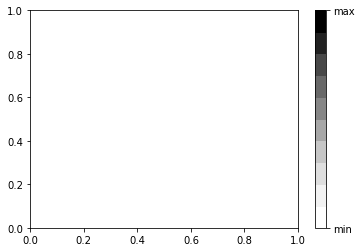

In [21]:
# cm.ScalarMappable()
cmap = plt.get_cmap('Greys', 10)
cbar = cm.ScalarMappable(cmap=cmap)
cbar.set_array(np.array([0,1]))
cb = plt.colorbar(cbar,ticks=[0,1],anchor=(0,0.5))
cb.ax.set_yticklabels(['min','max'])


In [22]:
plt.get_cmap()

In [23]:
r4 = r2.loc[r2['norm value']>0]
t = r4.groupby(['aggregated biome','aggregated taxon'])['norm value'].apply(lambda x: pd.cut(x,bins=bins).value_counts()/len(x)).reset_index()
u = t.loc[0,'level_2']
t2 = t.groupby(['aggregated biome','aggregated taxon','level_2']).apply(lambda x: print(x['norm value'].values[0])).reset_index()
t2

y = t.groupby(['aggregated biome','aggregated taxon'])['norm value'].apply(np.max).reset_index()
t3 = t.merge(y,left_on=['aggregated biome','aggregated taxon'],right_on=['aggregated biome','aggregated taxon'])
t3['val'] = t3['norm value_x']/t3['norm value_y']
t3

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.045454545454545456
0.13636363636363635
0.18181818181818182
0.045454545454545456
0.3181818181818182
0.22727272727272727
0.045454545454545456
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.19047619047619047
0.19047619047619047
0.38095238095238093
0.047619047619047616
0.09523809523809523
0.0
0.047619047619047616
0.0
0.047619047619047616
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.26666666666666666
0.0
0.0
0.2
0.06666666666666667
0.3333333333333333
0.13333333333333333
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4
0.4
0.2
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.03571428571428571
0.03571428571428571
0.03571428571428571
0.14285714285714285
0.2857142857142857
0.03571428571428571
0.21428571428571427
0.07142857142857142
0.10714285714285714
0.03571428571428571
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3333333333333333
0.1111111111111111
0.2222222222222222
0.2222222222222222
0.0
0.1111111111111111
0.0
0.0
0.0
0.0
0.0
0.0
0.

,aggregated biome,aggregated taxon,level_2,norm value_x,norm value_y,val
0,Boreal\nForests/\nTaiga,Acari,"(300.393, 558.229]",0.318182,0.318182,1.000000
1,Boreal\nForests/\nTaiga,Acari,"(558.229, 1037.374]",0.227273,0.318182,0.714286
2,Boreal\nForests/\nTaiga,Acari,"(86.985, 161.647]",0.181818,0.318182,0.571429
3,Boreal\nForests/\nTaiga,Acari,"(46.808, 86.985]",0.136364,0.318182,0.428571
4,Boreal\nForests/\nTaiga,Acari,"(1037.374, 1927.782]",0.045455,0.318182,0.142857
...,...,...,...,...,...,...
755,Tundra,Other,"(558.229, 1037.374]",0.000000,0.357143,0.000000
756,Tundra,Other,"(1037.374, 1927.782]",0.000000,0.357143,0.000000
757,Tundra,Other,"(1927.782, 3582.453]",0.000000,0.357143,0.000000
758,Tundra,Other,"(3582.453, 6657.377]",0.000000,0.357143,0.000000


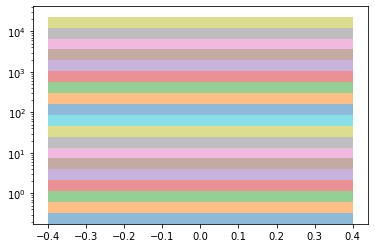

In [24]:
r3 = r2.loc[r2['norm value']>0,'norm value']
bins = np.logspace(np.log10(r3.min()),np.log10(r3.max()),20)
#plt.bar(x=0,bins
for i in range(1,len(bins)):
    plt.bar(x=0,height=bins[i]-bins[i-1],bottom=bins[i-1],log=True,alpha=0.5)
#r3.plot.hist(bins=np.logspace(np.log10(r3.min()),np.log10(r3.max()),20),logx=True)


In [25]:
#soil_stacked = soil_biome_means.stack().stack().reset_index()
#sb.violinplot(x='aggregated biome',y=0,hue='aggregated taxon',data=soil_stacked[soil_stacked['level_0']=='mean'])


In [26]:
sb.stripplot(x='index',y,soil_biome_means)

SyntaxError: positional argument follows keyword argument (<ipython-input-26-d7794881d58e>, line 1)

In [ ]:
soil_biome_means.sum().apply(print_u)

In [ ]:
soil_biome_means

In [ ]:
soil_site_data.loc[('Isoptera','Crops')]

In [ ]:
#t= soil_site_data.reset_index().pivot_table(index='aggregated taxon',columns='aggregated biome',values='norm value', aggfunc='median').T.reset_index()
t= soil_site_data.groupby(['aggregated taxon','aggregated biome']).median().reset_index().merge(pd.DataFrame(biome_area1),left_on='aggregated biome',right_index=True)
t.loc[:,'Total'] = (t.loc[:,'norm value']*t.loc[:,'area']).values
(t.pivot_table(values='Total',index='aggregated taxon',columns='aggregated biome',aggfunc=np.nansum)/1e18).sum(axis=1)


In [ ]:
soil_biome_means_unp = soil_site_data.groupby(['aggregated taxon','aggregated biome']).apply(lambda x: unp.uarray(nominal_values= x.mean(),std_devs=x.sem()))
soil_biome_means_unp = soil_biome_means_unp.reset_index()
biome_area = pd.read_csv('data/aggregated biomes data.csv')
biome_area1 = biome_area.groupby('aggregated biome 1')['area'].sum()
biome_area2 = biome_area.groupby('aggregated biome 2')['area'].sum()
# .pivot_table(columns='aggregated taxon',index='aggregated biome')
soil_biome_means_unp1 = soil_biome_means_unp.merge(pd.DataFrame(biome_area1),left_on='aggregated biome',right_index=True)
soil_biome_means_unp2 = soil_biome_means_unp[soil_biome_means_unp['aggregated taxon'].isin(['Formicidae','Isoptera'])]
soil_biome_means_unp2.loc[soil_biome_means_unp2.loc[:,'aggregated biome'].str.contains('Forest'),'aggregated biome'] = 'Forests'
soil_biome_means_unp2.loc[soil_biome_means_unp2.loc[:,'aggregated biome'].str.contains('Grass'),'aggregated biome'] = 'Shrubland/Grassland'
soil_biome_means_unp2 = soil_biome_means_unp2.merge(pd.DataFrame(biome_area2),left_on='aggregated biome',right_index=True)
part1 = soil_biome_means_unp1[soil_biome_means_unp1['aggregated taxon'].isin(['Acari','Collembola','Formicidae','Isoptera','Other'])]
part2 = soil_biome_means_unp2[soil_biome_means_unp2['aggregated taxon'].isin(['Formicidae','Isoptera'])]

In [ ]:
part1

In [ ]:
part1.loc[:,'Total'] = (part1.loc[:,'norm value']*part1.loc[:,'area']).values
part1.pivot_table(values='Total',index='aggregated taxon',columns='aggregated biome',aggfunc=np.nansum)/1e18

In [ ]:
u = part1.pivot_table(values='Total',index='aggregated taxon',columns='aggregated biome',aggfunc=np.nansum)/1e18
print(u['Boreal Forests/Taiga'].sum()*1e3)
u.sum()*1e3

In [ ]:
np.sqrt(part1.loc[non_na,'Total'].apply(lambda x: x.std_dev**2).sum())/1e15

In [ ]:
non_na = ~(part1['Total'].apply(lambda x: x.std_dev).isna())
(part1.loc[non_na,'Total'].sum()+part1.loc[~non_na,'Total'].apply(lambda x: x.nominal_value).sum())/1e18

In [ ]:
ax = ((part1.groupby('aggregated taxon').Total.sum()/1e18).apply(lambda x: x.nominal_value)/total_soil.nominal_value).plot.pie(colors=['#4285F4','#7CBB00','#FFBB00','#f44336','#9e59b3'])
plt.savefig('results/fig2a.svg', dpi=300)
(part1.groupby('aggregated taxon').Total.sum()/1e18).apply(lambda x: x.nominal_value)


In [ ]:
sp_soil_biome_means*

In [ ]:
sp_soil_site_taxa_mean = soil_data.groupby(['aggregated taxon','sub-phylum','aggregated biome','site','taxon'])['norm value'].mean().reset_index()
sp_soil_site_data = sp_soil_site_taxa_mean.groupby(['aggregated taxon','sub-phylum','aggregated biome','site'])['norm value'].sum()
sp_soil_biome_means = sp_soil_site_data.reset_index().pivot_table(index=['sub-phylum','aggregated taxon'],columns='aggregated biome',values='norm value', aggfunc=calc_uval)
sp_soil_biome_means = sp_soil_biome_means.drop('Mixed')
# area = biome_area.set_index('aggregated biome 1').loc[sp_soil_biome_means.columns,'area']
## new addition
area = biome_area.set_index('aggregated biome 1').merge(sp_soil_biome_means.T,left_index=True,right_index=True)['area']
area = area.reset_index().groupby('index').sum()['area']
##
tot_sp = (sp_soil_biome_means*area).groupby('sub-phylum').apply(np.nansum).sum()

ax = ((sp_soil_biome_means*area).groupby('sub-phylum').apply(np.nansum)/tot_sp.nominal_value).apply(lambda x: x.nominal_value).plot.pie(colors=['#4db6ac','#bdbdbd','#795548','#607d8b'])
# plt.savefig('results/fig2b.svg', dpi=300)
((sp_soil_biome_means*area).groupby('sub-phylum').apply(np.nansum)/tot_sp.nominal_value)

In [ ]:
fig,ax = plt.subplots(figsize=[5,5])
type(ax)

In [ ]:
group_sum.sort_values(ascending=False)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=[10,3],dpi=300)
ax = plt.subplot(1,2,1)
group_sum = ((part1.groupby('aggregated taxon').Total.sum()/1e18).apply(lambda x: x.nominal_value))
group_sum.index = ['acari\n(mites)','collembola\n(springtails)','formicidae\n(ants)','isoptera\n(termites)','other']
group_colors = pd.Series(['#4285F4','#7CBB00','#FFBB00','#f44336','#9e59b3'],index = group_sum.index)
group_sum.sort_values(ascending=False,inplace=True)

group_sum.sort_values(ascending=False).plot.bar(width = 0.6,color=group_colors.loc[group_sum.index],rot=0,ax=ax)
# ((part1.groupby('aggregated taxon').Total.sum()/1e18).apply(lambda x: x.nominal_value)).plot.bar(colors=['#4285F4','#7CBB00','#FFBB00','#f44336','#9e59b3'],rot=45,ax=ax)
ax.set_ylabel('Biomass [Gt C]')

# (part1.groupby('aggregated taxon').Total.sum()/1e18).apply(lambda x: x.nominal_value)
ax2 = plt.subplot(1,2,2)
subphyla_sum = ((sp_soil_biome_means*area).groupby('sub-phylum').apply(np.nansum)/1e18).apply(lambda x: x.nominal_value)
subphyla_sum.index = ['chelicerata','crustacea','hexapoda','myriapoda']
subphyla_colors = pd.Series(['#4db6ac','#bdbdbd','#795548','#607d8b'],index = subphyla_sum.index)
subphyla_sum.sort_values(ascending=False,inplace=True)
subphyla_sum.plot.bar(width = 0.5,color=subphyla_colors.loc[subphyla_sum.index],ax=ax2,rot=0)
ax.set_ylim([0,0.2])
ax2.set_ylim([0,0.2])
ax.set(yticks=np.arange(0,0.25,0.05))
ax2.set(yticks=np.arange(0,0.25,0.05))
# ax.set_ylabel('Biomass [Gt C]')
# plt.savefig('results/fig2b.svg', dpi=300)
plt.tight_layout()
ax.text(-1,0.21,'A',fontdict={'size':20})
ax2.text(-1,0.21,'B',fontdict={'size':20})
# plt.savefig('results/fig2.svg', dpi=300)
# plt.savefig('results/fig2.png', dpi=300)

# plt.savefig('results/fig2b.svg', dpi=300)
# ((sp_soil_biome_means*area).groupby('sub-phylum').apply(np.nansum)/tot_sp.nominal_value)


In [ ]:
ar_soil_site_taxa_mean = soil_data.groupby(['aggregated taxon','order','aggregated biome','site','taxon'])['norm value'].mean().reset_index()
ar_soil_site_data = ar_soil_site_taxa_mean.groupby(['aggregated taxon','order','aggregated biome','site'])['norm value'].sum()
ar_soil_biome_means = ar_soil_site_data.reset_index().pivot_table(index=['order'],columns='aggregated biome',values='norm value', aggfunc=calc_uval)
# ar_soil_site_data.reset_index().set_index('order').loc['Araneae']
(ar_soil_biome_means.loc['Araneae']*area).sum()/1e18
ar_soil_biome_means.loc['Araneae']

In [ ]:
# total_soil = (part1.groupby('aggregated taxon').Total.sum()/1e18).sum()
non_na = ~(part1['Total'].apply(lambda x: x.std_dev).isna())
total_soil =  (part1.loc[non_na,'Total'].sum()+part1.loc[~non_na,'Total'].apply(lambda x: x.nominal_value).sum())/1e18
total_soil

In [ ]:
part2 = part2[part2['aggregated biome']!='Tundra']
part2.loc[:,'Total'] = (part2.loc[:,'norm value']*part2.loc[:,'area']).values
part2.pivot_table(values='Total',index='aggregated taxon',columns='aggregated biome',aggfunc=sum)/1e18

In [ ]:
part2.groupby('aggregated taxon').Total.sum()/1e18

In [ ]:
total_soil = (part1.Total.sum()+part2.Total.sum())/1e18

In [ ]:
canopy_site_taxa_mean = canopy_data.groupby(['aggregated biome','site','taxon'])['norm value'].mean().reset_index()
canopy_site_data = canopy_site_taxa_mean.groupby(['aggregated biome','site'])['norm value'].sum()
canopy_biome_means = canopy_site_data.reset_index().pivot_table(index='aggregated biome',values='norm value', aggfunc=[calc_uval,'count'])

canopy_biome_means = canopy_biome_means.droplevel(axis=1,level=0)
canopy_biome_means.columns = ['mean','N']


def print_u(x):
    if type(x) != uncertainties.core.Variable:
        return '{:.0f}'.format(x )
    else: 
        return '{:.0f}'.format(x.nominal_value)+'±'+'{:.0f}'.format(x.std_dev)

canopy_biome_means_print = canopy_biome_means.applymap(print_u)
#soil_biome_means_print.to_csv('results/table_1.csv')
canopy_biome_means_print

In [ ]:
total_canopy = np.nansum(canopy_biome_means['mean']*area)/1e18
total_canopy

In [ ]:
surface_site_taxa_mean = surface_data.groupby(['aggregated biome','site','taxon'])['norm value'].mean().reset_index()
surface_site_data = surface_site_taxa_mean.groupby(['aggregated biome','site'])['norm value'].sum()
surface_biome_means = surface_site_data.reset_index().pivot_table(index='aggregated biome',values='norm value', aggfunc=[calc_uval,'count'])

surface_biome_means = surface_biome_means.droplevel(axis=1,level=0)
surface_biome_means.columns = ['mean','N']


def print_u(x):
    if type(x) != uncertainties.core.Variable:
        return '{:.0f}'.format(x )
    else: 
        return '{:.0f}'.format(x.nominal_value)+'±'+'{:.0f}'.format(x.std_dev)

surface_biome_means_print = surface_biome_means.applymap(print_u)
#soil_biome_means_print.to_csv('results/table_1.csv')
surface_biome_means_print

In [ ]:
total_surface = np.nansum(surface_biome_means['mean']*area)/1e18
total_surface

In [ ]:
surface_biome_mean = surface_data.groupby(['aggregated biome','site'])['numerical value'].sum().groupby('aggregated biome').agg(['mean','sem'])
surface_biome_mean = surface_biome_mean.merge(pd.DataFrame(biome_area1),left_index=True,right_index=True)
surface_biome_mean['unp']=unp.uarray(nominal_values=surface_biome_mean['mean'],std_devs=surface_biome_mean['sem'])
surface_biome_mean['Total'] = surface_biome_mean.unp*surface_biome_mean.area
surface_biome_mean.Total/1e18

In [ ]:
total_surface = surface_biome_mean.Total.sum()/1e18
total_surface

In [ ]:
overall_biomass = total_surface+total_canopy+total_soil
overall_biomass

In [ ]:


(pd.DataFrame([total_soil.nominal_value,total_canopy.nominal_value,total_surface.nominal_value],index=['Soil','Canopy','Aboveground'])/overall_biomass.nominal_value).plot.pie(y=0)
(pd.DataFrame([total_soil.nominal_value,total_canopy.nominal_value,total_surface.nominal_value],index=['Soil','Canopy','Aboveground'])/overall_biomass.nominal_value)

In [ ]:
total_surface+total_canopy+total_soil

In [ ]:
print(canopy_data.site.nunique())
print(surface_data.site.nunique())

In [ ]:
canopy_biome_means_bar = canopy_biome_means.copy()
ind = canopy_biome_means_bar.index.values
ind[0] = 'Boreal\nForests/\nTaiga'
ind[1] = 'Mediterranean\nForests,\nWoodlands\nand Scrub'
ind[2] = 'Temperate\nForests'
ind[3] = 'Tropical and\nSubtropical\nForests'
canopy_biome_means_bar.index = ind

surface_biome_means_bar = surface_biome_means.copy()
ind2 = surface_biome_means_bar.index.values

ind2[1] = 'Deserts\nand Xeric\nShrublands'
ind2[3] = 'Temperate\nGrasslands,\nSavannas and\nShrublands'
surface_biome_means_bar.index = ind2

fig = plt.subplots(figsize=[9,3])
ax = plt.subplot(1,2,1)
canopy_biome_means_bar['mean'].apply(lambda x: x.nominal_value).plot.bar(yerr=canopy_biome_means['mean'].apply(lambda x: x.std_dev),colors=['#4caf50'],rot=0,ax=ax)
ax.set_ylabel('biomass density [mg/m$^2$]')
ax.set_title('canopy arthropods')
ax.set_ylim([0,600])

ax2 = plt.subplot(1,2,2)
surface_biome_means_bar['mean'].apply(lambda x: x.nominal_value).plot.bar(yerr=surface_biome_means['mean'].apply(lambda x: x.std_dev),colors=['#8d6e63'],rot=0,ax=ax2)
ax.set_ylabel('biomass density [mg/m$^2$]')
ax2.set_title('aboveground arthropods')
ax2.set_ylim([0,6500])
plt.tight_layout()
plt.savefig('results/fig3.svg',dpi=300)
plt.savefig('results/fig3.png',dpi=300)

In [ ]:
site_units = mass_data.groupby('site').units.nunique()
cal_data=mass_data[mass_data.site.isin(site_units[site_units==2].index)]
cal_pvt = cal_data.pivot_table(index=['site','taxon'],columns='units',values='numerical value',aggfunc=np.nanmean)
conv_ratios = (cal_pvt['mg/m^2 (dry weight)']/cal_pvt['mg/m^2 (wet weight)']).reset_index()
print(conv_ratios[conv_ratios.site.str.startswith('Cow')].mean())
print(conv_ratios[conv_ratios.site.str.startswith('Cow')].sem())